In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../')
import fewshot.proto.sampler
import fewshot.proto.trainer
import fewshot.data

import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms
from torchvision import models
import torch.optim as optim


import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Exploring Prototypical Networks

We here check and iterate on implementation of prototypical networks. The main implementation is in `fewshot.proto` and is quite closely based on @oscarknagg's implementation [here](https://github.com/oscarknagg/few-shot/).

We're not reusing the implementation directly because I'm pretty sure there's at least one significant flaw with the implementation on that repo.



## Data Loading and Episodes

We follow the idea of putting all data in a single tensor. For an `n`-shot `k`-way episode with `q` queries, the tensor shape will be `((n+q)*k, n_channels, width, height)` - and the first dimension is split:
The first `n*k` items are the examples, and the last `q*k` examples are the queries.

We reimplemented this and added an episode viz function below:

In [3]:
train_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [4]:
ds = fewshot.proto.sampler.NShotFashionDataset('../data/fashion-dataset/styles_quoted.csv',
                                               '../data/fashion-dataset/images/',
                                               classlist=None,
                                               transform=test_transform)

In [5]:
n, k, q = 2, 10, 5
sampler = fewshot.proto.sampler.NShotTaskSampler(ds, episodes_per_epoch=10, n=n, k=k, q=q)
dl = torch.utils.data.DataLoader(ds, batch_sampler=sampler, num_workers=4)

In [6]:
episode = next(iter(dl))

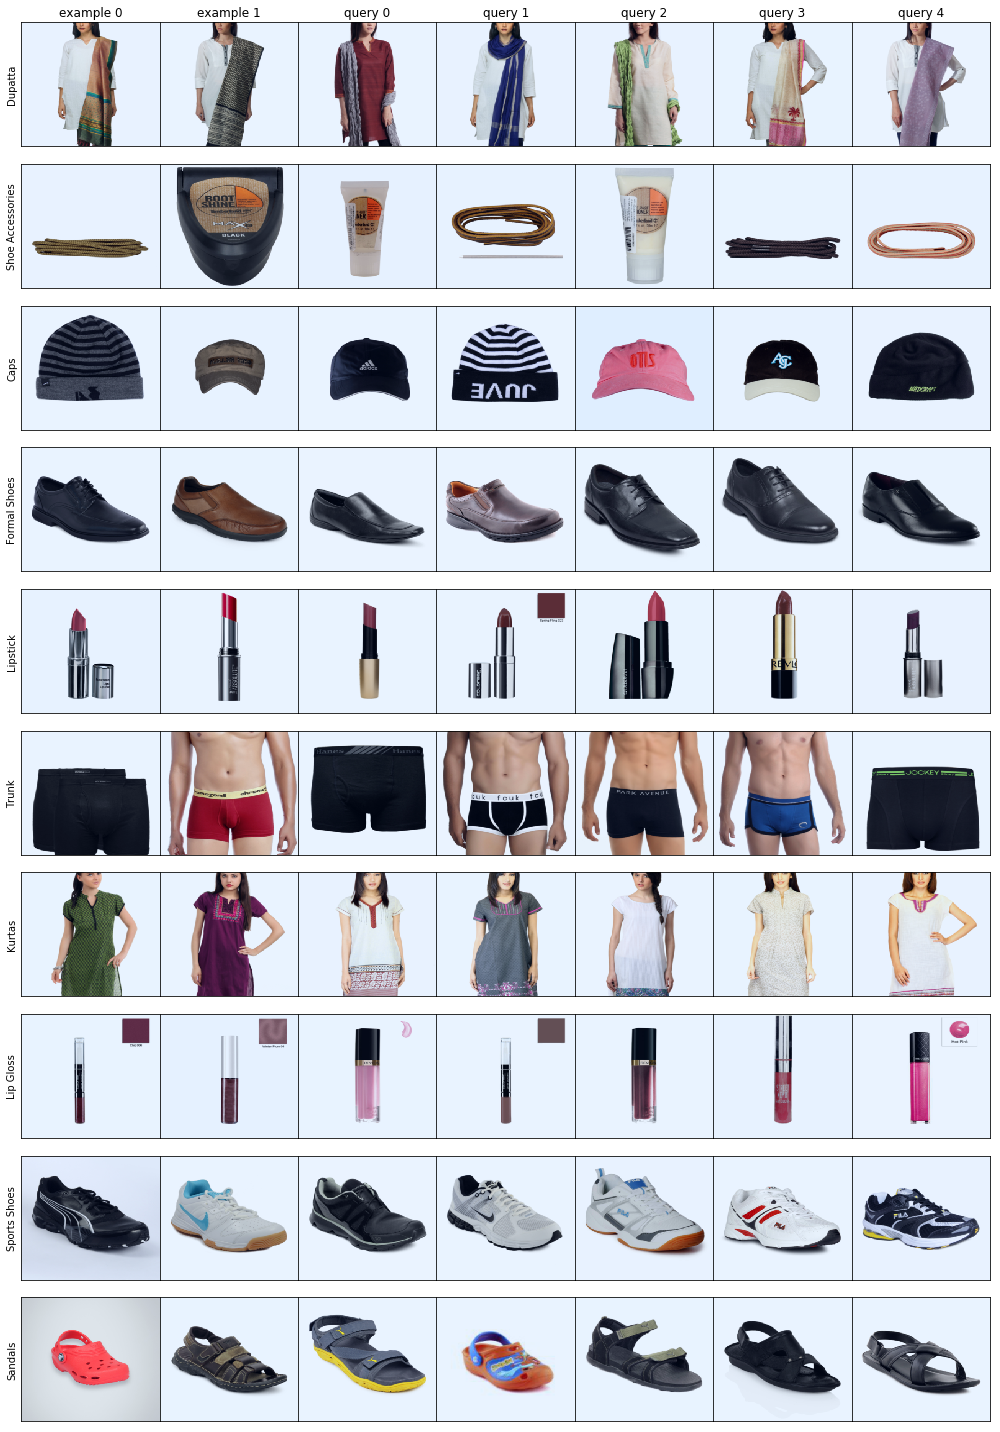

In [7]:
scale = 2
fewshot.proto.sampler.plot_nshot_episode(episode, n, k , q, scale)

## Training

Once we've set up our data appropriately, we just need to set up our training:

In [205]:
embedding_sz = 100
## smaller resnet cause overfitting. might still be way too large
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

## replacing the last layer with the dense layer we need
model.fc = nn.Linear(num_ftrs, 100)

In [206]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

Let's check that our loss goes to 0 on a single episode:

In [207]:
for _ in range(10):
    model.train()
    optimizer.zero_grad()
    X, _ = episode
    y = torch.tensor(np.broadcast_to(np.arange(10), (5, 10)).reshape((1, -1), order='F' )).squeeze()
    embeddings = model(X)
    n_embeds = model(X[:n*k])
    q_embeds= model(X[n*k:])
    centroids = fewshot.proto.trainer.compute_centroids(n_embeds, n, k)
    distances = fewshot.proto.trainer.pairwise_distances(centroids, q_embeds, matching_fn="l2").t()
    loss = loss_func(-distances, y)
    print("loss: ", loss.item())
    loss.backward()
    optimizer.step()

loss:  0.6901463270187378
loss:  0.09041422605514526
loss:  0.0007242107531055808
loss:  0.0006261730450205505
loss:  0.0013420295435935259
loss:  0.0009474182152189314
loss:  0.0005629158113151789
loss:  0.0001402473426423967
loss:  3.9939881389727816e-05
loss:  1.6365051124012098e-05


Looks like we can safely say it works.